# Two Networks (V1 and V2) - V1 receives an external stimulus

In [8]:
from brian2 import *
import scipy.io
import os
# Parameters
R             = 50  *Mohm          # membrane resitance [MOhm]
tauE_m        = 20.0 * ms          # excitatory neuron membrane time constant [ms]
tauI_m        = 10.0 * ms          # inhibitory neuron membrane time constant [ms]
cE_m          = tauE_m/R            # Capacitance excitatory neurons [nF]
cI_m          = tauI_m/R            # Capacitance excitatory neurons [nF]
tauRef        = 2.0 *ms            # refractory time [ms]
v_rest        = -70.0 *mV          # resting potential [mV]
Vt            = -50.0 *mV          # threshold [mV]
Vr            = -60.0 *mV          # reset [mV]  
tau_syn_e     = 0.1 *ms            # time constant for synapse [ms] (I'll tell more about it later)

# External input for assynchronous behavior
VextE         = 14.2 *mV           # External input in excitatory neurons
VextI         = 14.7 *mV           # External input in excitatory neurons


# Neuron model with alpha function for synpases
eqs_alphaE = '''
    dv/dt = (v_rest-v)/tau_m + (ie +a*SI(t,i)+ i_inj)/c_m + ((sigma*(tau_m**0.5)*xi)/c_m) : volt (unless refractory)
    
    die/dt = (2.7182818284590451*ye-ie)/tau_syn_e : ampere
    dye/dt = -ye/tau_syn_e                        : ampere
    i_inj : ampere
    sigma : ampere
    tau_m : second
    c_m   : farad 
    a     : 1
    '''

eqs_alphaI = '''
    dv/dt = (v_rest-v)/tau_m + (ie + i_inj)/c_m + ((sigma*(tau_m**0.5)*xi)/c_m) : volt (unless refractory)
    
    die/dt = (2.7182818284590451*ye-ie)/tau_syn_e : ampere
    dye/dt = -ye/tau_syn_e                        : ampere
    i_inj : ampere
    sigma : ampere
    tau_m : second
    c_m   : farad 
    '''

# Noise
sigmaV=3*mV

# Coefficient
coeffE=0.67957046
coeffI=2*coeffE

# Integration step
defaultclock.dt = 0.1*ms

# Synaptic weights
wEE = .01 *mV
wIE = .075 *mV
wEI = -.0375 *mV
wII = -.075 *mV

# Connection probability
plocal = 0.1

# Alpha (gradient)
alpha = 4

# duration
duration = 0.5*second

# Stimulus
stimV = 10.1*mV
stimDur = 200*ms

# Matrix of stimulus
netsteps = round(duration/defaultclock.dt)
a1 = np.zeros([3000,1]) #input given to v1 for fixed duration. 
a2 = (stimV/mV)*np.ones([int(stimDur/ms),1])
a3 = np.zeros([  int(netsteps - 3000 - (stimDur/ms)) , 1])
aareaone = np.vstack((a1,a2,a3)) 

timelen = len(aareaone)
aareaonenet = np.tile(aareaone,(1,1600))

# Path to .mat files
path=os.path.abspath(os.path.join(os.getcwd(), os.pardir))+'/Matlab/'

para={'NAreas':2,
     'speed'     : 3.5}     # axonal conduction velocity}

# Factor for long rante connections
para['muEE']     = .0375
para['muIE']     = .19/4 

# Fln
flnMatp = scipy.io.loadmat(path+'efelenMatpython.mat')
conn=flnMatp['flnMatpython'][:][:] #fln values..Cij is strength from j to i 
para['conn']=conn[:para["NAreas"],:para["NAreas"]]
# Hierarchy
hierVals = scipy.io.loadmat(path+'hierValspython.mat')
hierValsnew = hierVals['hierVals'][:]
hier=hierValsnew/max(hierValsnew)#hierarchy normalized. 
para['hier']=hier[:para["NAreas"]]
# Delay
distMatp = scipy.io.loadmat(path+'subgraphWiring29.mat')
distMat=distMatp['wiring'][:][:] #distances between areas values..
delayMat = distMat/para['speed']
para['delayMat']=delayMat[:para["NAreas"],:para["NAreas"]]


In [2]:
##################################### Alpha Function #############################################################

############################ V1
# Population of excitatory neurons
PE_alphaV1 = NeuronGroup(1600, eqs_alphaE, threshold='v>Vt', reset='v = Vr', refractory=2*ms, method='euler')
# Population of excitatory neurons
PI_alphaV1 = NeuronGroup(400, eqs_alphaI, threshold='v>Vt', reset='v = Vr', refractory=2*ms, method='euler')

# parameters
PE_alphaV1.v = v_rest + rand(len(PE_alphaV1)) * (Vt - v_rest)          
PE_alphaV1.tau_m = tauE_m     
PE_alphaV1.c_m = cE_m         
PE_alphaV1.i_inj=(VextE/R)                 
PE_alphaV1.sigma=(sigmaV/R)   
PE_alphaV1.a=1
# parameters
PI_alphaV1.v = v_rest + rand(len(PI_alphaV1)) * (Vt - v_rest)          
PI_alphaV1.tau_m = tauI_m     
PI_alphaV1.c_m = cI_m         
PI_alphaV1.i_inj=(VextI/R)           
PI_alphaV1.sigma=(sigmaV/R) 

# Stimulus on V1 excitatory neurons
SI=TimedArray((aareaonenet*mV)/R, dt=defaultclock.dt)


# Recurrent Synapses in V1
Cee_alphaV1 = Synapses(PE_alphaV1, PE_alphaV1, 'w:ampere', on_pre='ye += w',delay=2*ms)
Cie_alphaV1 = Synapses(PE_alphaV1, PI_alphaV1, 'w:ampere', on_pre='ye += w',delay=2*ms)
Cei_alphaV1 = Synapses(PI_alphaV1, PE_alphaV1, 'w:ampere', on_pre='ye += w',delay=2*ms)
Cii_alphaV1 = Synapses(PI_alphaV1, PI_alphaV1, 'w:ampere', on_pre='ye += w',delay=2*ms)

Cee_alphaV1.connect(p = plocal) 
Cie_alphaV1.connect(p = plocal) 
Cei_alphaV1.connect(p = plocal) 
Cii_alphaV1.connect(p = plocal)


Cee_alphaV1.w =  ((1+alpha*para["hier"][0])*(wEE/mV)/coeffE)*nA 
Cie_alphaV1.w =  ((1+alpha*para["hier"][0])*(wIE/mV)/coeffI)*nA
Cei_alphaV1.w = ((wEI/mV)/coeffE)*nA 
Cii_alphaV1.w = ((wII/mV)/coeffI)*nA

 

# Monitors
monitorsE_alphaV1 = SpikeMonitor(PE_alphaV1)
monitorsI_alphaV1 = SpikeMonitor(PI_alphaV1)
rateE_alphaV1 = PopulationRateMonitor(PE_alphaV1)
rateI_alphaV1 = PopulationRateMonitor(PI_alphaV1)

In [3]:

############################ V2
# Population of excitatory neurons
PE_alphaV2 = NeuronGroup(1600, eqs_alphaE, threshold='v>Vt', reset='v = Vr', refractory=2*ms, method='euler')
# Population of excitatory neurons
PI_alphaV2 = NeuronGroup(400, eqs_alphaI, threshold='v>Vt', reset='v = Vr', refractory=2*ms, method='euler')

# parameters
PE_alphaV2.v = v_rest + rand(len(PE_alphaV2)) * (Vt - v_rest)          
PE_alphaV2.tau_m = tauE_m     
PE_alphaV2.c_m = cE_m         
PE_alphaV2.i_inj=(VextE/R)                 
PE_alphaV2.sigma=(sigmaV/R)   
PE_alphaV2.a=0
# parameters
PI_alphaV2.v = v_rest + rand(len(PI_alphaV2)) * (Vt - v_rest)          
PI_alphaV2.tau_m = tauI_m     
PI_alphaV2.c_m = cI_m         
PI_alphaV2.i_inj=(VextI/R)           
PI_alphaV2.sigma=(sigmaV/R) 

# Recurrent Synapses in V2
Cee_alphaV2 = Synapses(PE_alphaV2, PE_alphaV2, 'w:ampere', on_pre='ye += w',delay=2*ms)
Cie_alphaV2 = Synapses(PE_alphaV2, PI_alphaV2, 'w:ampere', on_pre='ye += w',delay=2*ms)
Cei_alphaV2 = Synapses(PI_alphaV2, PE_alphaV2, 'w:ampere', on_pre='ye += w',delay=2*ms)
Cii_alphaV2 = Synapses(PI_alphaV2, PI_alphaV2, 'w:ampere', on_pre='ye += w',delay=2*ms)


Cee_alphaV2.connect(p = plocal) 
Cie_alphaV2.connect(p = plocal) 
Cei_alphaV2.connect(p = plocal) 
Cii_alphaV2.connect(p = plocal) 

Cee_alphaV2.w =  ((1+alpha*para["hier"][1])*(wEE/mV)/coeffE)*nA
Cie_alphaV2.w =  ((1+alpha*para["hier"][1])*(wIE/mV)/coeffI)*nA
Cei_alphaV2.w =  ((wEI/mV)/coeffE)*nA 
Cii_alphaV2.w =  ((wII/mV)/coeffI)*nA

# Monitors
monitorsE_alphaV2 = SpikeMonitor(PE_alphaV2)
monitorsI_alphaV2 = SpikeMonitor(PI_alphaV2)
rateE_alphaV2 = PopulationRateMonitor(PE_alphaV2)
rateI_alphaV2 = PopulationRateMonitor(PI_alphaV2)

In [4]:
# Long Range Connections

Cee_alphaV1V2 = Synapses(PE_alphaV1, PE_alphaV2, 'w:ampere', on_pre='ye += w')
Cie_alphaV1V2 = Synapses(PE_alphaV1, PI_alphaV2, 'w:ampere', on_pre='ye += w')

Cee_alphaV1V2.connect(p = plocal) 
Cie_alphaV1V2.connect(p = plocal) 

Cee_alphaV1V2.w =  (((1 + alpha * para["hier"][1]) * para['muEE'] * para["conn"][1,0])/coeffE)*nA 
Cie_alphaV1V2.w =  (((1 + alpha * para["hier"][1]) * para['muIE'] * para["conn"][1,0])/coeffI)*nA 

# Mean for delay distribution 
meanlr = para["delayMat"][1,0]
# Standard deviation for delay distribution
varlr =  0.1*meanlr

Cee_alphaV1V2.delay = np.random.normal(meanlr,varlr,len(Cee_alphaV1V2.w))*ms
Cie_alphaV1V2.delay = np.random.normal(meanlr,varlr,len(Cie_alphaV1V2.w))*ms

# Run simulation
run(duration)

INFO       width adjusted from 10. ms to 10.1 ms [brian2.monitors.ratemonitor.adjusted_width]


Text(0.5, 0, 'Time (seconds)')

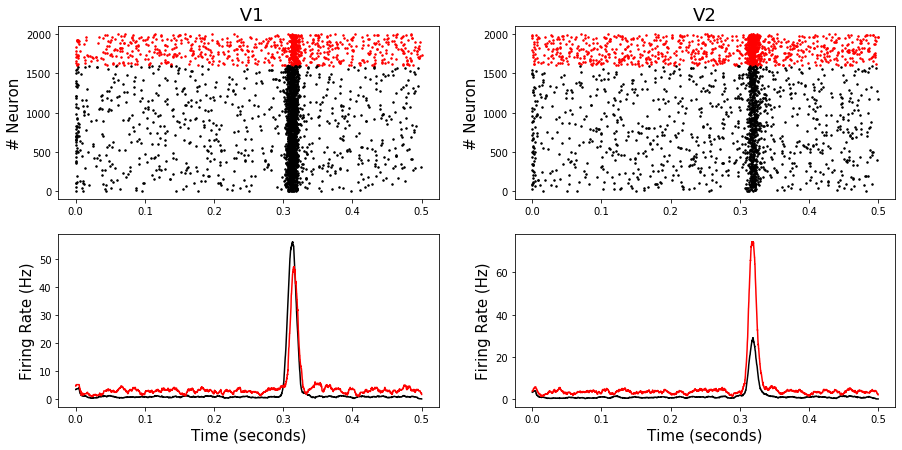

In [5]:
rcParams['figure.figsize'] = 15, 7
subplot(221)
plot(monitorsI_alphaV1.t/second,1600+monitorsI_alphaV1.i,'r.',markersize=3)
plot(monitorsE_alphaV1.t/second,monitorsE_alphaV1.i,'k.',markersize=3)
ylabel('# Neuron',fontsize=15)
title (' V1',fontsize=18)


subplot(222)

plot(monitorsI_alphaV2.t/second,1600+monitorsI_alphaV2.i,'r.',markersize=3)
plot(monitorsE_alphaV2.t/second,monitorsE_alphaV2.i,'k.',markersize=3)
ylabel('# Neuron',fontsize=15)
title ('V2',fontsize=18)

subplot(223)
plot(rateE_alphaV1.t/second, rateE_alphaV1.smooth_rate(window='flat', width=10*ms)/Hz,'k')
plot(rateI_alphaV1.t/second, rateI_alphaV1.smooth_rate(window='flat', width=10*ms)/Hz,'r')

ylabel('Firing Rate (Hz)',fontsize=15)
xlabel('Time (seconds)',fontsize=15)


subplot(224)
plot(rateE_alphaV2.t/second, rateE_alphaV2.smooth_rate(window='flat', width=10*ms)/Hz,'k')
plot(rateI_alphaV2.t/second, rateI_alphaV2.smooth_rate(window='flat', width=10*ms)/Hz,'r')
ylabel('Firing Rate (Hz)',fontsize=15)
xlabel('Time (seconds)',fontsize=15)